In [ ]:
import numpy as np
import pandas as pd
import random
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, BatchNormalization
from keras.layers import LSTM
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import csv


In [ ]:
# 6 features accl x,y,z + gyro x,y,z
feature_count = 6
# 32 time steps
time_step = 32
# Ratio
sample_multiplier = 4.5
# Epoch
epoch = 20

In [ ]:
# 25 Files Out Of 29 are selected as Training Data
training_file_info = {'./edit_subject_001_01__x.csv': './edit_subject_001_01__y.csv',
                          './edit_subject_001_02__x.csv': './edit_subject_001_02__y.csv',
                          './edit_subject_001_03__x.csv': './edit_subject_001_03__y.csv',
                          './edit_subject_001_04__x.csv': './edit_subject_001_04__y.csv',
                          './edit_subject_001_05__x.csv': './edit_subject_001_05__y.csv',
                          './edit_subject_001_06__x.csv': './edit_subject_001_06__y.csv',
                          './edit_subject_001_07__x.csv': './edit_subject_001_07__y.csv',
                          './edit_subject_001_08__x.csv': './edit_subject_001_08__y.csv',
                          './edit_subject_002_01__x.csv': './edit_subject_002_01__y.csv',
                          './edit_subject_002_02__x.csv': './edit_subject_002_02__y.csv',
                          './edit_subject_002_03__x.csv': './edit_subject_002_03__y.csv',
                          './edit_subject_002_04__x.csv': './edit_subject_002_04__y.csv',
                          './edit_subject_002_05__x.csv': './edit_subject_002_05__y.csv',
                          './edit_subject_003_01__x.csv': './edit_subject_003_01__y.csv',
                          './edit_subject_003_02__x.csv': './edit_subject_003_02__y.csv',
                          './edit_subject_003_03__x.csv': './edit_subject_003_03__y.csv',
                          './edit_subject_004_01__x.csv': './edit_subject_004_01__y.csv',
                          './edit_subject_004_02__x.csv': './edit_subject_004_02__y.csv',
                          './edit_subject_005_01__x.csv': './edit_subject_005_01__y.csv',
                          './edit_subject_005_02__x.csv': './edit_subject_005_02__y.csv',
                          './edit_subject_005_03__x.csv': './edit_subject_005_03__y.csv'}

# 4 Files Out Of 29 are selected as Validation Data
validation_file_info = {'./edit_subject_006_01__x.csv': './edit_subject_006_01__y.csv',
                        './edit_subject_006_02__x.csv': './edit_subject_006_02__y.csv',
                        './edit_subject_006_03__x.csv': './edit_subject_006_03__y.csv',
                        './edit_subject_008_01__x.csv': './edit_subject_008_01__y.csv'}

In [ ]:
def read_file(input_file, output_file, is_valid):
  print("Processing: " + input_file)
  x_data = pd.read_csv(input_file, names=['acc.x', 'acc.y', 'acc.z', 'gyro.x', 'gyro.y', 'gyro.z'])
  # Mean Subtraction
  x_data = x_data - x_data.mean()
  x_data = x_data.values
  y_data = pd.read_csv(output_file, names=['label']).values
  all_count = np.unique(y_data, return_counts = True)
  min_count = min(all_count[1])
  accept_prob = [1,1,1,1]
  for i in range(len(all_count[0])):
    accept_prob[all_count[0][i]] = (min_count/all_count[1][i]) * sample_multiplier
  if is_valid:
    accept_prob = [1,1,1,1]
  print(accept_prob)
  lstm_x_input = []
  for i in range(int(time_step/4), y_data.shape[0]):
    sample = []
    for j in range((i*4)-(time_step), (i*4)):
      sample.append(x_data[j])
    lstm_x_input.append(sample)
  lstm_x_input = np.asarray(lstm_x_input)
  y_data = y_data[0: y_data.shape[0] - int(time_step/4)]

  print("Before down-sampling")
  print("lstm_x_input: " + str(lstm_x_input.shape))
  print("y_data: " + str(y_data.shape))
  print("label dist.: " + str(np.unique(y_data, return_counts = True)))
  
  lstm_x_select_data = []
  y_select_data = []
  for i in range(0, y_data.shape[0]):
    # [0 ~ 1]
    val = random.random()
    #print(val)
    if val <= accept_prob[y_data[i][0]]:
      #print(str(i) + ":" + str(val) + "<=" + str(accept_prob[y_data[i][0]]))
      lstm_x_select_data.append(lstm_x_input[i])
      y_select_data.append(y_data[i])
  lstm_x_select_data = np.asarray(lstm_x_select_data)
  y_select_data = np.asarray(y_select_data)

  print("After down-sampling")
  print("lstm_x_select_data: " + str(lstm_x_select_data.shape))
  print("y_select_data: " + str(y_select_data.shape))
  print("label dist.: " + str(np.unique(y_select_data, return_counts = True)))

  return (lstm_x_select_data, np.squeeze(y_select_data))

In [ ]:
def readTraining(): 
    x_input = np.empty((0, time_step, feature_count))
    y_input = np.empty((0,))
    for input_file, output_file in training_file_info.items():
        x_temp, y_temp = read_file(input_file, output_file, False)
        x_input = np.append(x_input, x_temp, axis=0)
        y_input = np.append(y_input, y_temp, axis=0)
    print('Training X: ' + str(x_input.shape))
    print('Training Y: ' + str(y_input.shape))
    print("label dist.: " + str(np.unique(y_input, return_counts = True)))
    return (x_input, y_input)

In [ ]:
(x_train, y_train) = readTraining()

Processing: ./edit_subject_001_01__x.csv
[0.5811989100817438, 4.5, 4.060279187817259, 2.0911764705882354]
Before down-sampling
lstm_x_input: (8526, 32, 6)
y_data: (8526, 1)
label dist.: (array([0, 1, 2, 3]), array([5497,  711,  788, 1530]))
After down-sampling
lstm_x_select_data: (6248, 32, 6)
y_select_data: (6248, 1)
label dist.: (array([0, 1, 2, 3]), array([3219,  711,  788, 1530]))
Processing: ./edit_subject_001_02__x.csv
[0.4020576131687243, 4.5, 3.829703832752613, 1.5415497896213184]
Before down-sampling
lstm_x_input: (15904, 32, 6)
y_data: (15904, 1)
label dist.: (array([0, 1, 2, 3]), array([10927,   977,  1148,  2852]))
After down-sampling
lstm_x_select_data: (9280, 32, 6)
y_select_data: (9280, 1)
label dist.: (array([0, 1, 2, 3]), array([4303,  977, 1148, 2852]))
Processing: ./edit_subject_001_03__x.csv
[0.39660817181770563, 4.5, 2.738245931283906, 4.271509167842031]
Before down-sampling
lstm_x_input: (10116, 32, 6)
y_data: (10116, 1)
label dist.: (array([0, 1, 2, 3]), array([7

In [ ]:
y_train_cat = []
for y in y_train:
    if y == 0:
        y_train_cat.append([1,0,0,0])
    elif y == 1:
        y_train_cat.append([0,1,0,0])
    elif y == 2:
        y_train_cat.append([0,0,1,0])
    else:
        y_train_cat.append([0,0,0,1])
y_train = np.asarray(y_train_cat)
print(y_train.shape)

(96992, 4)


In [ ]:
def readValidation(): 
    x_input = np.empty((0, time_step, feature_count))
    y_input = np.empty((0,))
    for input_file, output_file in validation_file_info.items():
        x_temp, y_temp = read_file(input_file, output_file, True)
        x_input = np.append(x_input, x_temp, axis=0)
        y_input = np.append(y_input, y_temp, axis=0)
    print('Validation X: ' + str(x_input.shape))
    print('Validation Y: ' + str(y_input.shape))
    print("label dist.: " + str(np.unique(y_input, return_counts = True)))
    return (x_input, y_input)

In [ ]:
(x_val, y_val) = readValidation()

Processing: ./edit_subject_006_01__x.csv
[1, 1, 1, 1]
Before down-sampling
lstm_x_input: (11212, 32, 6)
y_data: (11212, 1)
label dist.: (array([0, 1, 2, 3]), array([8691,  575,  826, 1120]))
After down-sampling
lstm_x_select_data: (11212, 32, 6)
y_select_data: (11212, 1)
label dist.: (array([0, 1, 2, 3]), array([8691,  575,  826, 1120]))
Processing: ./edit_subject_006_02__x.csv
[1, 1, 1, 1]
Before down-sampling
lstm_x_input: (14002, 32, 6)
y_data: (14002, 1)
label dist.: (array([0, 1, 2, 3]), array([11388,   544,   482,  1588]))
After down-sampling
lstm_x_select_data: (14002, 32, 6)
y_select_data: (14002, 1)
label dist.: (array([0, 1, 2, 3]), array([11388,   544,   482,  1588]))
Processing: ./edit_subject_006_03__x.csv
[1, 1, 1, 1]
Before down-sampling
lstm_x_input: (10391, 32, 6)
y_data: (10391, 1)
label dist.: (array([0, 1, 2, 3]), array([7605,  344,  400, 2042]))
After down-sampling
lstm_x_select_data: (10391, 32, 6)
y_select_data: (10391, 1)
label dist.: (array([0, 1, 2, 3]), array

In [ ]:
y_val_cat = []
for y in y_val:
    if y == 0:
        y_val_cat.append([1,0,0,0])
    elif y == 1:
        y_val_cat.append([0,1,0,0])
    elif y == 2:
        y_val_cat.append([0,0,1,0])
    else:
        y_val_cat.append([0,0,0,1])
y_val = np.asarray(y_val_cat)
print(y_val.shape)

(46582, 4)


In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
import tensorflow as tf
model = Sequential()
model.add(LSTM(units = 100, input_shape=(time_step, feature_count), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 100))
model.add(Dropout(0.2))
model.add(Dense(128, activation="relu"))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['categorical_accuracy', f1_m, precision_m, recall_m])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32, 100)           42800     
_________________________________________________________________
dropout (Dropout)            (None, 32, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               12928     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 136,644
Trainable params: 136,644
Non-trainable params: 0
__________________________________________________

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(96992, 32, 6)
(96992, 4)
(46582, 32, 6)
(46582, 4)


In [ ]:
history = model.fit(x_train, y_train, epochs=epoch, batch_size=64, shuffle=False, validation_data=(x_val, y_val))

Epoch 1/20
1516/1516 [==============================] - 13s 9ms/step - loss: 0.7108 - categorical_accuracy: 0.6894 - f1_m: 0.6556 - precision_m: 0.7007 - recall_m: 0.6310 - val_loss: 0.6416 - val_categorical_accuracy: 0.6766 - val_f1_m: 0.6719 - val_precision_m: 0.6809 - val_recall_m: 0.6633
Epoch 2/20
1516/1516 [==============================] - 13s 8ms/step - loss: 0.5298 - categorical_accuracy: 0.7792 - f1_m: 0.7689 - precision_m: 0.7865 - recall_m: 0.7576 - val_loss: 0.6013 - val_categorical_accuracy: 0.7186 - val_f1_m: 0.7138 - val_precision_m: 0.7225 - val_recall_m: 0.7057
Epoch 3/20
1516/1516 [==============================] - 13s 8ms/step - loss: 0.4574 - categorical_accuracy: 0.8187 - f1_m: 0.8115 - precision_m: 0.8244 - recall_m: 0.8025 - val_loss: 0.5590 - val_categorical_accuracy: 0.7453 - val_f1_m: 0.7409 - val_precision_m: 0.7498 - val_recall_m: 0.7327
Epoch 4/20
1516/1516 [==============================] - 13s 8ms/step - loss: 0.4013 - categorical_accuracy: 0.8425 - f1_m

In [ ]:
def plot_history(history):
    # plot loss
    plt.title('Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
    
    # plot accuracy
    plt.title('Accuracy')
    plt.plot(history.history['categorical_accuracy'], color='blue', label='train')
    plt.plot(history.history['val_categorical_accuracy'], color='red', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

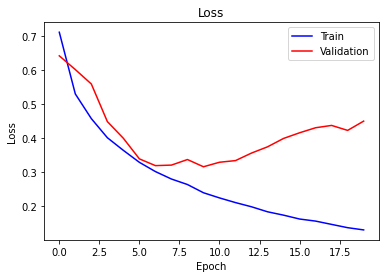

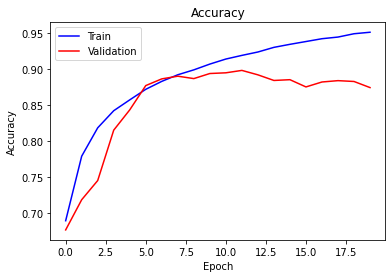

In [ ]:
plot_history(history)

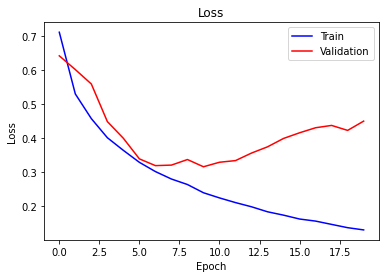

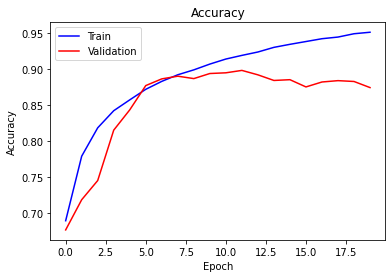

In [ ]:
plot_history(history)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

testing_file_info = {'./edit_subject_007_01__x.csv': './edit_subject_007_01__y.csv',
                        './edit_subject_007_02__x.csv': './edit_subject_007_02__y.csv',
                        './edit_subject_007_03__x.csv': './edit_subject_007_03__y.csv',
                        './edit_subject_007_04__x.csv': './edit_subject_007_04__y.csv'}

output_file_info = {'./edit_subject_007_01__x.csv': './edit_subject_007_01__y_prediction.csv',
                        './edit_subject_007_02__x.csv': './edit_subject_007_02__y_prediction.csv',
                        './edit_subject_007_03__x.csv': './edit_subject_007_03__y_prediction.csv',
                        './edit_subject_007_04__x.csv': './edit_subject_007_04__y_prediction.csv'}
for input_file, input_file_y_time in testing_file_info.items():
  print(input_file)
  x_test_data = pd.read_csv(input_file, names=['acc.x', 'acc.y', 'acc.z', 'gyro.x', 'gyro.y', 'gyro.z'])
  # Mean Subtraction
  x_test_data = x_test_data - x_test_data.mean()
  x_test_data = x_test_data.values
  y_true_label = pd.read_csv(input_file_y_time, names=['label'])
  print(y_true_label.shape)
  lstm_x_input = []
  for i in range(int(time_step/4), y_true_label.shape[0]):
    sample = []
    for j in range((i*4)-(time_step), (i*4)):
      sample.append(x_test_data[j])
    lstm_x_input.append(sample)
  x_test_data = np.asarray(lstm_x_input)
  print(x_test_data.shape)
  y_test_pred = model.predict(x_test_data)
  res = []
  for i in range(0, len(y_test_pred)):
    res.append(np.argmax(y_test_pred[i]))
  np.asarray(res)
  print("True: " + str(np.unique(y_true_label, return_counts = True)))
  print("Predict: " + str(np.unique(res, return_counts = True)))
  outfile = open(output_file_info.get(input_file),'w')
  out = csv.writer(outfile)
  out.writerows(map(lambda x: [x], res))
  outfile.close()  
  for i in range(int(time_step/4)):
    res.insert(0,0)
  y_test = np.array(y_true_label)
  # # precision tp / (tp + fp)
  # precision = precision_score(y_test, res, average='weighted')
  # # recall: tp / (tp + fn)
  # recall = recall_score(y_test, res, average='weighted')
  # # f1: 2 tp / (2 tp + fp + fn)
  # f1 = f1_score(y_test, res, average='weighted')
  # print('Precision: %f; Recall: %f; F1 score: %f' % (precision, recall, f1))
  matrix = confusion_matrix(res, y_test)
  print(matrix)

./edit_subject_007_01__x.csv
(10775, 1)
(10767, 32, 6)
True: (array([0, 1, 2, 3]), array([7141,  382,  540, 2712]))
Predict: (array([0, 1, 2, 3]), array([6684,  395,  569, 3119]))
[[5726   65   52  849]
 [  53  315    2   25]
 [  65    0  477   27]
 [1297    2    9 1811]]
./edit_subject_007_02__x.csv
(10804, 1)
(10796, 32, 6)
True: (array([0, 1, 2, 3]), array([7503,  121,  542, 2638]))
Predict: (array([0, 1, 2, 3]), array([5272,  137,  526, 4861]))
[[4670   43   76  491]
 [  44   76    3   14]
 [  57    0  462    7]
 [2732    2    1 2126]]
./edit_subject_007_03__x.csv
(10344, 1)
(10336, 32, 6)
True: (array([0, 1, 2, 3]), array([6362,  352,  426, 3204]))
Predict: (array([0, 1, 2, 3]), array([4956,  409,  427, 4544]))
[[4258   54   59  593]
 [  79  293    0   37]
 [  51    0  364   12]
 [1974    5    3 2562]]
./edit_subject_007_04__x.csv
(9213, 1)
(9205, 32, 6)
True: (array([0, 1, 2, 3]), array([6925,  249,  405, 1634]))
Predict: (array([0, 1, 2, 3]), array([5754,  290,  428, 2733]))
[[5

In [ ]:
testing_file_info = {'./edit_subject_009_01__x.csv': './edit_subject_009_01__y_time.csv',
                          './edit_subject_010_01__x.csv': './edit_subject_010_01__y_time.csv',
                          './edit_subject_011_01__x.csv': './edit_subject_011_01__y_time.csv',
                          './edit_subject_012_01__x.csv': './edit_subject_012_01__y_time.csv'}

output_file_info = {'./edit_subject_009_01__x.csv': './edit_subject_009_01__y_prediction.csv',
                          './edit_subject_010_01__x.csv': './edit_subject_010_01__y_prediction.csv',
                          './edit_subject_011_01__x.csv': './edit_subject_011_01__y_prediction.csv',
                          './edit_subject_012_01__x.csv': './edit_subject_012_01__y_prediction.csv'}

for input_file, input_file_y_time in testing_file_info.items():
        print(input_file)
        x_test_data = pd.read_csv(input_file, names=['acc.x', 'acc.y', 'acc.z', 'gyro.x', 'gyro.y', 'gyro.z'])
        # Mean Subtraction
        x_test_data = x_test_data - x_test_data.mean()
        x_test_data = x_test_data.values
        y_test_time = pd.read_csv(input_file_y_time, names=['label'])
        print(y_test_time.shape)
        lstm_x_input = []
        for i in range(int(time_step/4), y_test_time.shape[0]):
          sample = []
          for j in range((i*4)-(time_step), (i*4)):
            sample.append(x_test_data[j])
          lstm_x_input.append(sample)
        x_test_data = np.asarray(lstm_x_input)
        print(x_test_data.shape)
        y_test_pred = model.predict(x_test_data)
        res = []
        for i in range(0, len(y_test_pred)):
          res.append(np.argmax(y_test_pred[i]))
        np.asarray(res)
        print(np.unique(res, return_counts = True))
        outfile = open(output_file_info.get(input_file),'w')
        out = csv.writer(outfile)
        out.writerows(map(lambda x: [x], res))
        outfile.close()

./edit_subject_009_01__x.csv
(8798, 1)
(8790, 32, 6)
(array([0, 1, 2, 3]), array([6376,  494,   91, 1829]))
./edit_subject_010_01__x.csv
(12105, 1)
(12097, 32, 6)
(array([0, 1, 2, 3]), array([6162,  417,  466, 5052]))
./edit_subject_011_01__x.csv
(11995, 1)
(11987, 32, 6)
(array([0, 1, 2, 3]), array([8400,  466,  697, 2424]))
./edit_subject_012_01__x.csv
(10555, 1)
(10547, 32, 6)
(array([0, 1, 2, 3]), array([7692,  653,  839, 1363]))
